In [24]:
seed = 42


import torch
torch.manual_seed(seed)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import numpy as np
import string
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms

In [25]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from pathlib import Path 
dataset_root = Path("/content/drive/MyDrive/data") 

In [27]:
class MyDataset(VisionDataset):

    def __init__(self,
                 root: str,
                 train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train
        digit='0123456789'
        self.classes= list(string.ascii_lowercase)+list(string.ascii_uppercase)+list(digit)

        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}
        data_path = os.path.join(self.root, 'letters.pkl')
         
        with open(data_path, "rb") as f:
            dataX1, dataY1 = pickle.load(f)
            a1=np.stack((dataX1,dataX1,dataX1),axis=-1)
            self.data = a1
            self.targets = [self.class_to_idx[i] for i in dataY1]

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index])
#         target = self.targets[index] if self.targets else len(self.classes)
        target = self.targets[index] 

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

In [28]:
!pip install albumentations --upgrade
# data.data.shape

In [29]:
# a=np.array([1,2,3,4,5,6,7,8]).reshape(4,2)
# a
# a=np.stack((a,a,a,a,a),axis=0)
# a.shape
# a=np.stack((a,a,a),axis=-1)
# a.shape

In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [31]:
# dataset_root="C:/Users/iaksh/YandexDisk/__Cs_center/_Project_2/"

data = MyDataset(
    root=dataset_root,
    train=True,
    transform=transforms.ToTensor(),
)

In [32]:
means = data.data.mean(axis=(0,1,2))/255
stds = data.data.std(axis=(0,1,2))/255

In [33]:
means,stds

(array([0.87174763, 0.87174763, 0.87174763]),
 array([0.25635803, 0.25635803, 0.25635803]))

In [34]:
data = MyDataset(
    root=dataset_root,
    train=True,
    transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize(means, stds)
              ])
)

In [35]:
# len=data.data.shape[0]
len(data.classes)

62

In [36]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [62496, 15624], 
    generator=torch.Generator().manual_seed(42),
)

In [37]:
train_data, test_data = torch.utils.data.random_split(
    train_data, 
    [46872, 15624], 
    generator=torch.Generator().manual_seed(42),
)

In [38]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 
def train(epoch, dataloader, model, loss_fn, optimizer, show_progr=True, scheduler=None):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
#         print(y)
#         print(X.shape)
#         y= torch.tensor(y)
        X, y = X.to(device),y.to(device)
        # Compute prediction error
        pred = model(X)
#         print(y.shape,pred.shape)

        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())

            if show_progr:
                show_progress(t)
    
    if scheduler is not None:
        scheduler.step()

In [39]:
def test(epoch, dataloader, model, loss_fn, show_progr=True):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    
    if show_progr:
        show_progress(epoch+1)

In [40]:
def create_FullyConv_model():
    return nn.Sequential(
              nn.Conv2d(3, 64, 3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(2, stride=2),
              nn.Conv2d(64, 128, 3, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(2, stride=2),
              nn.Conv2d(128, 256, 3, padding=1), # 8
              nn.BatchNorm2d(256),
              nn.ReLU(),
              nn.MaxPool2d(2, stride=2),
              nn.Conv2d(256, 512, 3, padding=1), # 4
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.MaxPool2d(2, stride=2),
              nn.Conv2d(512, 1024, 3, padding=1), # 2
              nn.BatchNorm2d(1024),
              nn.ReLU(),
              nn.MaxPool2d(2, stride=2),
              nn.Conv2d(1024, 62, 1), # 1
              nn.BatchNorm2d(62),
              nn.Flatten(),
              nn.Softmax(dim=1)
          )

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [42]:
data.data.shape

(78120, 32, 32, 3)

In [43]:
batch_size = 128
train_aug_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size) # это не настоящий val dataloader


for X, y in train_aug_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.int64


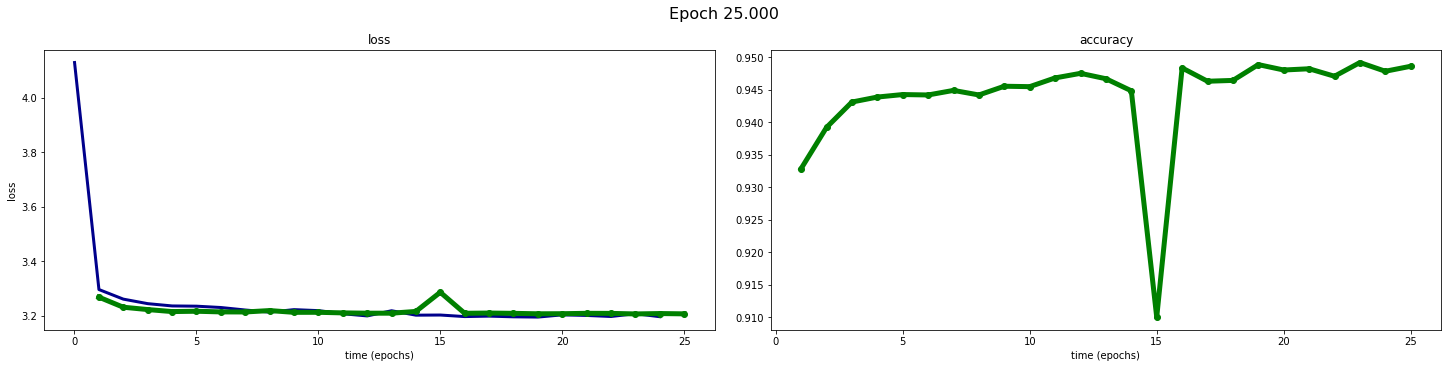

100%|██████████| 25/25 [14:48<00:00, 35.54s/it]


In [44]:
model = create_FullyConv_model()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

interval = 1000
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

epochs = 25
for t in trange(epochs):
    train(t, train_aug_dataloader, model, loss_fn, optimizer, show_progr=True, scheduler=None)
    test(t, val_dataloader, model, loss_fn, show_progr=True)